<a href="https://colab.research.google.com/github/JAZ201107/PyTorch-DL/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Table of contents**<a id='toc0_'></a>

- [Image Encoder](#toc1_)
- [Text Encoder](#toc2_)
- [Projection Head](#toc3_)
- [CLIP Model](#toc4_)
- [Training Process](#toc5_)
- [Inference](#toc6_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


In [3]:
!pip install -q kaggle

In [4]:
from google.colab import userdata
import os

KaggleKey = userdata.get('KaggleKey')
KaggleUserName = userdata.get('KaggleUserName')

os.environ['KAGGLE_USERNAME'] = KaggleUserName
os.environ['KAGGLE_KEY'] = KaggleKey

!kaggle datasets download adityajn105/flickr8k
!unzip /content/flickr8k.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.02G/1.04G [00:10<00:00, 150MB/s]
100% 1.04G/1.04G [00:10<00:00, 102MB/s]


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from dataclasses import dataclass


import transformers
from transformers import DistilBertTokenizer

from dataclasses import dataclass

import  matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-5-f135a81e9755>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
@dataclass
class ImageConfig:
    model_name: str = "resnet50"
    trainable: bool = True
    pretrained = True

    image_embedding = 2048


@dataclass
class TextConfig:
    dim: int = 768
    out_dim: int = 768
    in_dim: int = 768
    hidden_dim: int = 3072
    num_heads: int = 12
    num_layers: int = 6
    vocab_size: int = 30522
    max_position_embeddings: int = 512
    pad_token_id: int = 0
    layer_norm_eps: float = 1e-12
    hidden_dropout_prob: float = 0.1
    attention_dropout_prob: float = 0.1
    dropout: float = 0.1

    text_embedding = 768

    trainable = True



class CFG:
    debug = False
    # ---- Data ----
    image_path = "/content/Images"
    captions_path = "/content/captions.txt"
    batch_size = 32
    num_workers = 2
    size = 224  # image size

    # ----  Optimization ----
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8

    # ---- Training ----
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---- Model ----
    image_config = ImageConfig()
    text_config = TextConfig()
    temperature = 1.0
    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

    # ---- Tokenizer ----
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

In [7]:
class AvgMeter:
    def __init__(self, name="Metric"):

        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = 0, 0, 0

    def update(self, value, count=1):
        self.count += count
        self.sum += value * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

In [8]:
def get_lr(optimizer):
    for p in optimizer.param_groups:
        return p["lr"]

In [9]:
class CLIPDataset(Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(os.path.join(CFG.image_path, self.image_filenames[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)["image"]
        item["image"] = torch.tensor(image).permute(2, 0, 1).float()
        item["caption"] = self.captions[idx]

        return item

    def __len__(self):
        return len(self.image_filenames)


def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

# <a id='toc1_'></a>[Image Encoder](#toc0_)


Here we use ViT as the Image Encoder same as the origin paper.


In [10]:
import timm


class ImageEncoder(nn.Module):
    def __init__(
        self,
        config,
    ):
        super().__init__()

        self.model = timm.create_model(
            config.model_name,
            pretrained=config.pretrained,
            num_classes=0,
            global_pool="avg",
        )

        self.set_trainable(config.trainable)

    def set_trainable(self, trainable):
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

# <a id='toc2_'></a>[Text Encoder](#toc0_)

We use DistillBert as our text encoder. The Distill Bert is the distilled version of the Bert model. It is smaller and faster than the original Bert


In [11]:
class DistillBertSdpaAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.dropout = nn.Dropout(config.dropout)
        self.q_lin = nn.Linear(config.in_dim, config.in_dim, bias=True)
        self.k_lin = nn.Linear(config.in_dim, config.in_dim, bias=True)
        self.v_lin = nn.Linear(config.in_dim, config.in_dim, bias=True)

        self.out_lin = nn.Linear(config.in_dim, config.in_dim, bias=True)

    def forward(self, q, k, v, mask=None):
        q = self.q_lin(q)
        k = self.k_lin(k)
        v = self.v_lin(v)

        attn = torch.matmul(q, k.transpose(-2, -1))
        if mask is not None:
            mask = mask.unsqueeze(1).expand(-1, attn.size(1), -1)
            attn.masked_fill_(mask == 0, -np.inf)
        attn = attn / (q.size(-1) ** 0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.matmul(attn, v)
        out = self.out_lin(out)

        return out

In [12]:
class GELUActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        sqrt_2_pi = torch.sqrt(torch.tensor(2 * np.pi))
        return 0.5 * x * (1 + torch.tanh(sqrt_2_pi * (x + 0.044715 * torch.pow(x, 3))))

In [13]:
class FFN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.dropout = nn.Dropout(config.dropout)
        self.lin1 = nn.Linear(config.in_dim, config.hidden_dim, bias=True)
        self.lin2 = nn.Linear(config.hidden_dim, config.in_dim, bias=True)

        self.activation = GELUActivation()

    def forward(self, x):
        x = self.lin1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.lin2(x)

        return x

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.attention = DistillBertSdpaAttention(config)
        self.sa_layer_norm = nn.LayerNorm(config.in_dim)
        self.ffn = FFN(config)

        self.output_layer_norm = nn.LayerNorm(config.in_dim, eps=1e-12)

    def forward(self, x, mask=None):

        x = x + self.attention(x, x, x, mask=mask)
        x = self.sa_layer_norm(x)

        x = x + self.ffn(x)
        x = self.output_layer_norm(x)

        return x

In [15]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layer = nn.ModuleList(
            [TransformerBlock(config) for _ in range(config.num_layers)]
        )

    def forward(self, x, mask=None):
        for layer in self.layer:
            x = layer(x, mask=mask)

        return x

In [16]:
x = torch.tensor([1,2])
dtype = x.dtype
dtype

torch.int64

In [17]:
y = torch.tensor([1.2, 1.2]).to(dtype)
y.dtype

torch.int64

In [51]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.in_dim, padding_idx=config.pad_token_id
        )
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.in_dim
        )

        self.LayerNorm = nn.LayerNorm(config.dim, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob, inplace=False)

    def forward(self, x):
        dtype = x.dtype
        x = self.word_embeddings(x)
        x = x + self.position_embeddings(
            torch.arange(x.size(1)).unsqueeze(0).to(x.device)
        )

        x = self.LayerNorm(x)
        x = self.dropout(x)

        return x

In [52]:
x = torch.arange(3)
x.device

device(type='cpu')

In [53]:
class TextEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.transformer = Transformer(config)

        # Load the pre-trained model from Hugging Face
        self._load_from_hugging_face()
        self.set_trainable(config.trainable)

        # Using the CLS token hidden representation as the sentence's embedding
        self.target_token_id = 0

    def set_trainable(self, trainable):
        for p in self.parameters():
            p.requires_grad = trainable

    def _load_from_hugging_face(self):
        hf = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.load_state_dict(hf.state_dict())

    def forward(self, input_ids, attention_mask=None):
        input_ids = input_ids.long()
        hidden_states = self.embeddings(input_ids)
        # attention_mask = (input_ids != 0).long()
        hidden_states = self.transformer(hidden_states, attention_mask)
        return hidden_states[
            :, self.target_token_id, :
        ]  # Return the [CLS] token representation

# <a id='toc3_'></a>[Projection Head](#toc0_)


In [54]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim,
        dropout,
    ):
        super().__init__()

        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()

        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected  # Redidual connection
        x = self.layer_norm(x)

        return x

# <a id='toc4_'></a>[CLIP Model](#toc0_)


In [55]:
class CLIPModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.image_encoder = ImageEncoder(config.image_config)
        self.text_encoder = TextEncoder(config.text_config)
        self.image_projection_head = ProjectionHead(
            embedding_dim=config.image_config.image_embedding,
            projection_dim = config.projection_dim,
            dropout = config.dropout
        )
        self.text_projection_head = ProjectionHead(
            embedding_dim=config.text_config.text_embedding,
            projection_dim = config.projection_dim,
            dropout = config.dropout
        )

        self.temperature = config.temperature

    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(batch["input_ids"], batch["attention_mask"])

        # Projection to same
        image_features = self.image_projection_head(image_features)
        text_features = self.text_projection_head(text_features)

        # Calculate the loss
        logits = (
            torch.matmul(image_features, text_features.transpose(0, 1))
            / self.temperature
        )  # The similarities between the image and text
        image_similarity = torch.matmul(
            image_features, image_features.transpose(0, 1)
        )  # The similarities between the images
        texts_similarity = torch.matmul(
            text_features, text_features.transpose(0, 1)
        )  # The similarities between the texts

        targets = F.softmax(
            (image_similarity + texts_similarity) / (2 * self.temperature), dim=-1
        )  #

        texts_loss = cross_entropy_loss(logits, targets, reduction="none")
        images_loss = cross_entropy_loss(
            logits.transpose(0, 1), targets.transpose(0, 1), reduction="none"
        )

        loss = (texts_loss + images_loss) / 2.0
        return loss.mean()


def cross_entropy_loss(logits, targets, reduction="none"):
    log_softmax = nn.LogSoftmax(dim=-1)

    loss = (-targets * log_softmax(logits)).sum(dim=-1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

# <a id='toc5_'></a>[Training Process](#toc0_)


In [56]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(CFG.captions_path)
    max_id = len(dataframe) if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    # train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    # valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    train_dataframe = dataframe.iloc[train_ids].reset_index(drop = True)
    valid_dataframe = dataframe.iloc[valid_ids].reset_index(drop = True)
    print(f"{len(train_dataframe)} training samples,{len(valid_dataframe)} validation samples,")
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [57]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))

    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))

    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(valid_loss=loss_meter.avg)

    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel(CFG).to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {
            "params": itertools.chain(
                model.image_projection_head.parameters(), model.text_projection_head.parameters()
            ),
            "lr": CFG.head_lr,
            "weight_decay": CFG.weight_decay,
        },
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float("inf")
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

In [58]:
main()

32364 training samples,8091 validation samples,
Epoch: 1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
token = tokenizer("a a group of people dancing in a party party party",  padding=True, truncation=True, max_length=CFG.max_length)

In [ ]:
CFG.max_length

In [ ]:
token

# <a id='toc6_'></a>[Inference](#toc0_)


In [59]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel(CFG).to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection_head(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [60]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

32364 training samples,8091 validation samples,


<ipython-input-59-1407335af405>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=CFG.device))


  0%|          | 0/253 [00:00<?, ?it/s]

In [73]:
def fine_matches(model, image_embeddings, query, image_filenames, n=9):
    # 1. Tokenize the query
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }

    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=1)
    text_features_n = F.normalize(text_features, p=2, dim=1)
    text_embeddings = model.text_projection_head(text_features_n)
    dot_similarity = (image_embeddings_n @ text_embeddings.T).squeeze(0)
    print(dot_similarity.shape)

    values, indices = torch.topk(dot_similarity.squeeze(-1), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

In [74]:
image_embeddings.shape

torch.Size([8091, 256])

torch.Size([8091, 1])


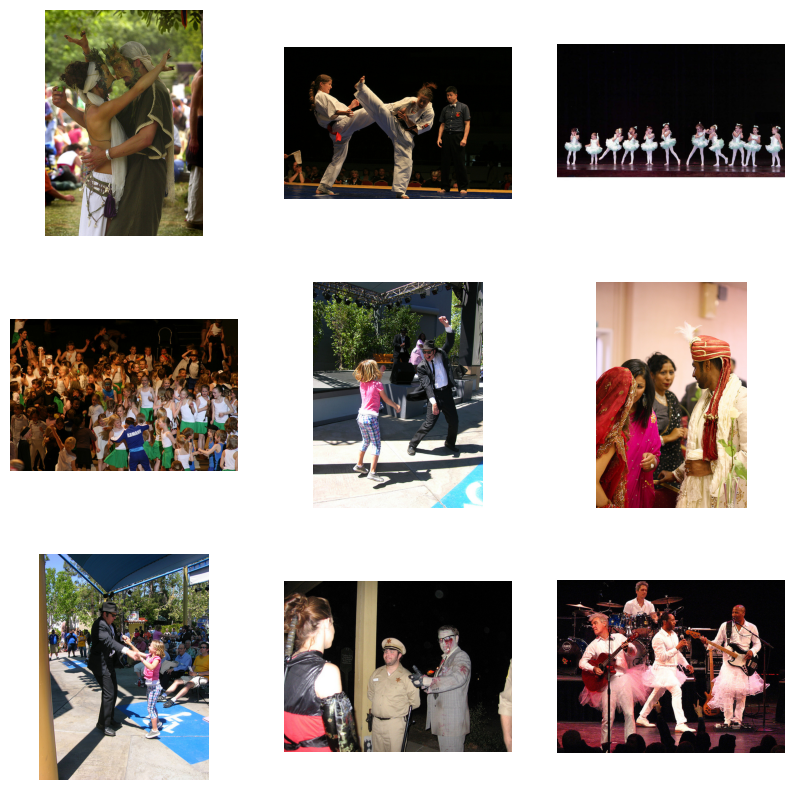

In [76]:
fine_matches(
    model,
    image_embeddings,
    query="a group of people dancing in a party",
    image_filenames=valid_df["image"].values,
    n=9,
)